In [1]:
import json
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

In [2]:
def load_json_data(filename):
    """Load JSON data from the specified file."""
    with open(filename, 'r') as file:
        return json.load(file)

In [3]:
data1 = load_json_data('GenCode_Results_Llama_1b.json')
data2 = load_json_data('GenCode_Results_Llama_1b_PromptTuned.json')
data3 = load_json_data('GenCode_Results_Llama_1b_OneShot.json')

In [4]:
data = [data1, data2, data3]
task_ids = [set(entry["task_id"] for entry in group) for group in data]
common_task_ids = set.intersection(*task_ids)

filtered_data = [
    [entry for entry in group if entry["task_id"] in common_task_ids]
    for group in data
]
data1, data2, data3 = filtered_data

In [5]:
def plot_attempts(data):
    num_groups = len(data)

    # Preprocessing
    attempts = [[] for _ in range(num_groups)]
    results = [[] for _ in range(num_groups)]
    max_attempt = [0] * num_groups
    total_counts = [[] for _ in range(num_groups)]
    success_counts = [[] for _ in range(num_groups)]

    for i in range(num_groups):
        attempts[i] = [entry["attempt"] for entry in data[i]]
        results[i] = [entry["result"] for entry in data[i]]

        max_attempt[i] = max(attempts[i]) if attempts[i] else 0
        attempt_range = range(max(max_attempt) + 1)  # Define x-axis range based on max attempt

        total_counts[i] = [attempts[i].count(attempt) for attempt in attempt_range]
        success_counts[i] = [
            sum(1 for j, attempt in enumerate(attempts[i]) if attempt == a and results[i][j] == 1)
            for a in attempt_range
        ]

    # Generate distinct colors for each group
    base_color_total = np.array(mcolors.to_rgb("lightslategray"))
    base_color_success = np.array(mcolors.to_rgb("green"))
    group_colors_total = [
        base_color_total * (1.2 - 0.35 * i) for i in range(num_groups)
    ]

    # Plotting
    x = np.arange(len(attempt_range))  # Shared x-axis for all groups
    width = 0.24  # Smaller bar width for better fit
    space = 0.05  # Space between groups

    fig, ax = plt.subplots(figsize=(9, 5))  # Reduced figure size

    model_labels = ["Llama 3.2 1B", "Llama 3.2 1B Prompt-Tuned", "Llama 3.2 1B One-Shot Example"]

    # Plot bars dynamically for each group
    for i in range(num_groups):
        offset = (i - num_groups // 2) * (width + space)
        bars_total = ax.bar(
            x + offset, total_counts[i], width, label=f"Total Count {model_labels[i]}", color=group_colors_total[i]
        )
        if i == 2:
            bars_success = ax.bar(
                x + offset, success_counts[i], width + 0.01, label="Correct Rust Code Generated", color=base_color_success
            )
        else:
            bars_success = ax.bar(
                x + offset, success_counts[i], width + 0.01, color=base_color_success
            )

        # Annotate bars
        for bar_total, bar_success in zip(bars_total, bars_success):
            # Total count
            height_total = bar_total.get_height()
            if height_total > 0:
                ax.annotate(f'{int(height_total)}',
                            xy=(bar_total.get_x() + bar_total.get_width() / 2, height_total),
                            xytext=(0, 3), textcoords="offset points", ha='center', va='bottom', fontsize=10)
            # Success count
            height_success = bar_success.get_height()
            if height_success > 0:
                ax.annotate(f'{int(height_success)}',
                            xy=(bar_success.get_x() + bar_success.get_width() / 2, height_success),
                            xytext=(0, 3), textcoords="offset points", ha='center', va='bottom', color="white", fontsize=10)

    # Title and labels
    ax.set_xlabel("Attempts", fontsize=14)
    ax.set_ylabel("Count", fontsize=14)
    ax.set_xticks(x)
    ax.set_xticklabels([str(a) for a in attempt_range], fontsize=12)
    ax.legend(loc='upper right', fontsize=12)

    plt.tight_layout()
    plt.show()


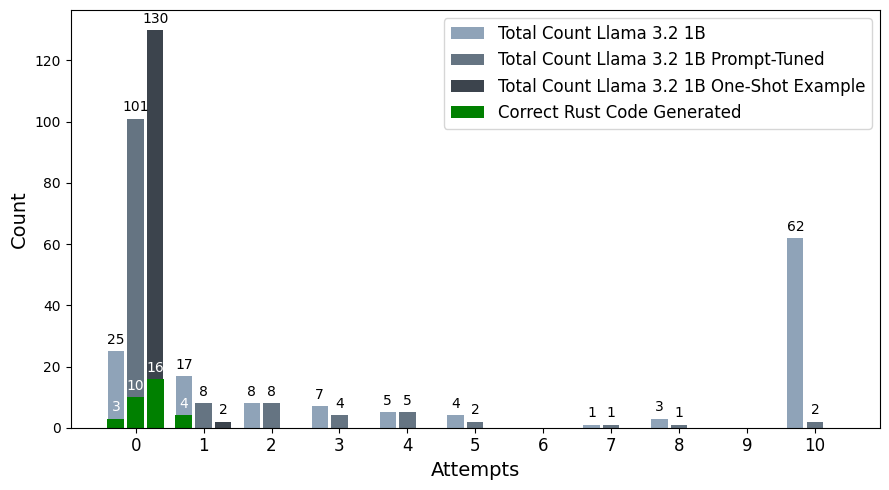

In [6]:
plot_attempts([data1, data2, data3])

In [13]:
def extract_task_ids_and_cumulative_results(sorted_data, max_attempt=0):
    """Extract task IDs and calculate the cumulative results."""
    x = []  # Task IDs
    cumulative_results = []  # Cumulative results (sum of 1s)
    cumulative_sum = 0
    task_ids_processed = []  # Keep track of processed task IDs

    for entry in sorted_data:
        if entry["attempt"] > max_attempt:
            continue

        # Extract task ID number from the task_id field
        task_id_num = int(entry["task_id"].split("/")[1])
        task_ids_processed.append(entry["task_id"])
        x.append(task_id_num)

        # Calculate cumulative sum of results (only 1 for success)
        result = entry["result"]
        cumulative_sum += result
        cumulative_results.append(cumulative_sum)

    return x, cumulative_results

def plot_cumulative_results(data):

    num_groups = len(data)
    colors = ['blue', 'orange', 'green']

    plt.figure(figsize=(10, 6))

    model_labels = ["Llama 3.2 1B", "Llama 3.2 1B Prompt-Tuned", "Llama 3.2 1B One-Shot Example"]


    for i in range(1):
        x, cumulative_results = extract_task_ids_and_cumulative_results(data[i], 10)
        plt.plot(x, cumulative_results, marker='o', linestyle='-', linewidth=1, color=colors[i],
                 alpha=0.2, label=f'{model_labels[i]} (Attempts > 1)')

    for i in range(num_groups):
        x, cumulative_results = extract_task_ids_and_cumulative_results(data[i])
        plt.plot(x, cumulative_results, marker='o', linestyle='-', linewidth=2, color=colors[i],
                 label=model_labels[i])

    # Add a y=x line for comparison
    max_value = max(max(x), max(cumulative_results))  # Determine the maximum value for scaling
    plt.plot([0, max_value], [0, max_value], color='red', linestyle='--', linewidth=2, label='Perfect Solutions (y = x)')

    # Add labels and title
    plt.xlabel('Task ID (Prompt)')
    plt.ylabel('Cumulative Result (Sum of Correct Results)')

    # Set x-ticks for better visibility (show every 5th task ID)
    plt.xticks(np.arange(0, max(x)+1, 5))  # Display every 5th tick on the x-axis

    plt.grid()

    plt.legend()

    # Set limits for the y-axis
    plt.ylim(0, max(cumulative_results) + 1)  # Set y-limits based on cumulative results
    plt.xlim(0, max_value)  # Set x-limits to match the maximum value

    plt.tight_layout()
    plt.show()

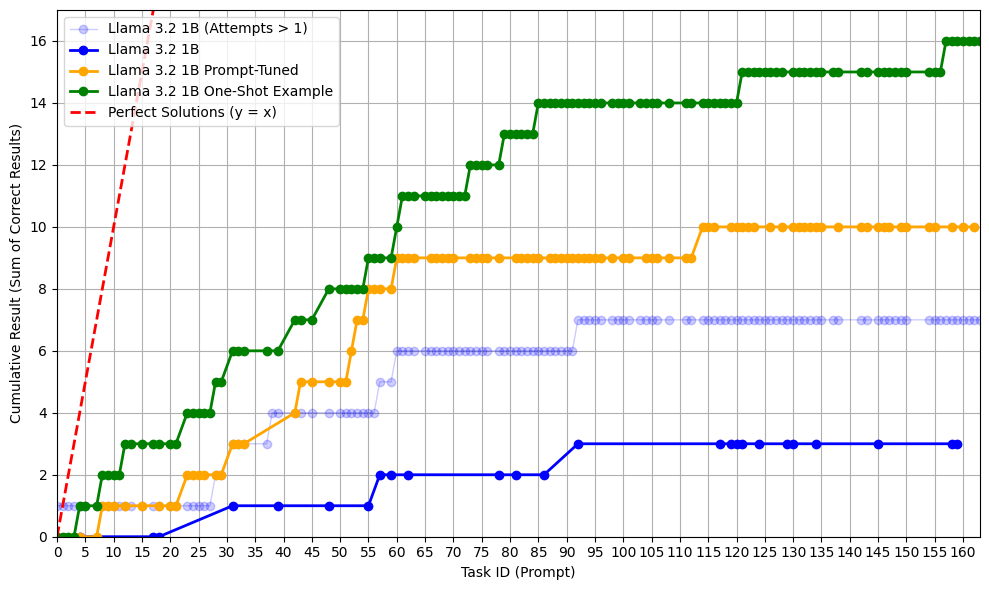

In [14]:
plot_cumulative_results([data1, data2, data3])

In [9]:
def print_example_code(data, idx=0):
    task_id = data[idx]["task_id"]
    prompt = data[idx]["instruction"]
    code = data[idx]["generated_code"]
    result = data[idx]["result"]

    print("Task " + task_id + " (" + str(result) + "):")
    print("Example Prompt:")
    print(prompt)
    print("\nGenerated Code:")
    print(code)

In [10]:
print_example_code(data2, 90)

Task Rust/114 (1):
Example Prompt:
Write a Rust function `min_sub_array_sum(nums: Vec<i64>) -> i64` to solve the following problem:
Given an array of integers nums, find the minimum sum of any non-empty sub-array
of nums.

Generated Code:
use std::{slice::Iter, cmp::{max, self}, mem::replace, collections::{HashSet, HashMap}, ops::Index, ascii::AsciiExt};
use rand::Rng;
use regex::Regex;
use md5;
use std::any::{Any, TypeId};

fn min_sub_array_sum(nums: Vec<i64>) -> i64{
    let mut res = i64::MAX;
    for i in 0..nums.len() {
        let mut sum = 0;
        for j in i..nums.len() {
            sum += nums[j];
            if sum < res {
                res = sum;
            }
        }
    }
    return res;
}


In [12]:
model_labels = ["Llama 3.2 1B", "Llama 3.2 1B Prompt-Tuned", "Llama 3.2 1B One-Shot Example"]
for idx, data in enumerate([data1, data2, data3]):
    total_results = len(data)  # Total number of results
    correct_results = sum(entry["result"] for entry in data)  # Count correct results (where result is 1)

    # Calculate percentage of correct results
    percentage_correct = (correct_results / total_results) * 100 if total_results > 0 else 0

    # Print the results
    print(model_labels[idx])
    print(f'Total Results: {total_results}')
    print(f'Correct Results: {correct_results}')
    print(f'Percentage of Correct Results: {percentage_correct:.2f}%\n')

Llama 3.2 1B
Total Results: 132
Correct Results: 7
Percentage of Correct Results: 5.30%

Llama 3.2 1B Prompt-Tuned
Total Results: 132
Correct Results: 10
Percentage of Correct Results: 7.58%

Llama 3.2 1B One-Shot Example
Total Results: 132
Correct Results: 16
Percentage of Correct Results: 12.12%

